## An attempt to break captcha using naive network

In [49]:
from captcha.image import ImageCaptcha
import matplotlib 
matplotlib.use('Agg') 
from matplotlib import pyplot as plt
import numpy as np
import random
import keras
import tensorflow as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from keras.utils import multi_gpu_model
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

import string
# What all to include in the captcha
characters =  string.ascii_uppercase + string.digits 
print(characters)

#width and height of the captcha
# number of characters in captcha and number of classes captcha can take characters from
width, height, n_len, n_class = 60, 60, 2, len(characters)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


# Data Generator

In [3]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
#             print("randome_str:", random_str)
            X[i] = generator.generate_image(random_str)
            # Range of j is 4
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

# Test Generator

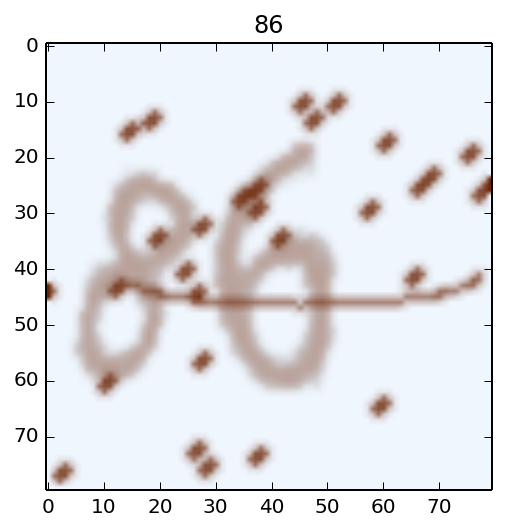

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# Network structure

In [5]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(32*2**i,(3, 3), activation='relu')(x)
    x = Conv2D(32*2**i,(3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(input=input_tensor, output=x)
# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
model = multi_gpu_model(model, gpus=4)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


# Network structure visualization

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 80, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 80, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 80, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

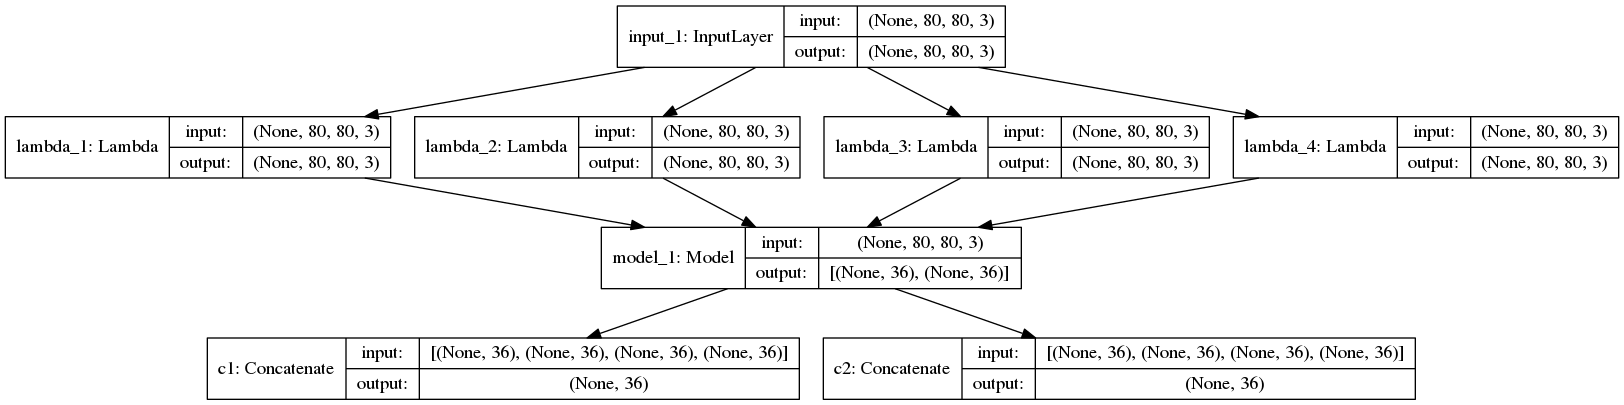

In [6]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
model.summary()

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# Training

In [7]:
model.fit_generator(gen(64), samples_per_epoch=25600, nb_epoch=3,
                    validation_data=gen(), nb_val_samples=1280)

Epoch 1/3
25600/25600 [==============================] - 2543s 99ms/step - loss: 0.5155 - c1_loss: 0.2517 - c2_loss: 0.2638 - c1_acc: 0.9303 - c2_acc: 0.9304 - val_loss: 0.3097 - val_c1_loss: 0.1366 - val_c2_loss: 0.1731 - val_c1_acc: 0.9851 - val_c2_acc: 0.9826
Epoch 2/3
25600/25600 [==============================] - 2542s 99ms/step - loss: 0.0838 - c1_loss: 0.0312 - c2_loss: 0.0526 - c1_acc: 0.9909 - c2_acc: 0.9892 - val_loss: 0.3148 - val_c1_loss: 0.1306 - val_c2_loss: 0.1842 - val_c1_acc: 0.9856 - val_c2_acc: 0.9806
Epoch 3/3
25600/25600 [==============================] - 2539s 99ms/step - loss: 0.0810 - c1_loss: 0.0303 - c2_loss: 0.0507 - c1_acc: 0.9916 - c2_acc: 0.9900 - val_loss: 0.3136 - val_c1_loss: 0.1384 - val_c2_loss: 0.1752 - val_c1_acc: 0.9864 - val_c2_acc: 0.9834


/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=25600, epochs=3, validation_steps=1280)`
  from ipykernel import kernelapp as app


# Save model

In [1]:
model.save_weights('cnn_alphanum_weights.h5')

NameError: name 'model' is not defined

# Load weights

In [7]:
import os
fname = 'cnn_alphanum_weights.h5'
os.path.isfile(fname) :
    model.load_weights('cnn_alphanum_weights.h5')

# Test Model

(-0.5, 79.5, 79.5, -0.5)

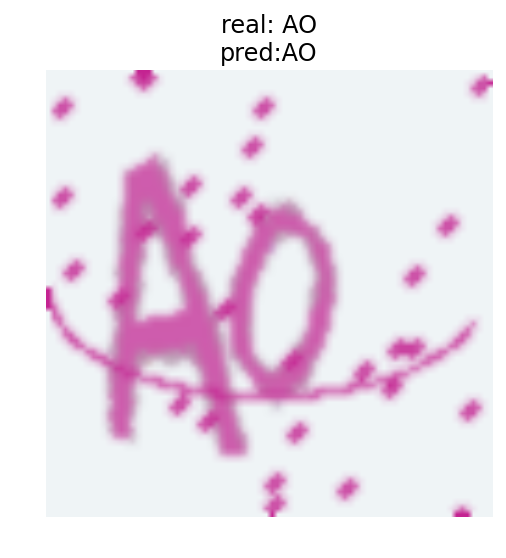

In [17]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# Calculate the overall model accuracy

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=1000):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

 80%|████████  | 803/1000 [00:54<00:11, 16.42it/s]